In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

<a href="https://www.kaggle.com/datasets/rpaguirre/tesla-stock-price/data">Data Source</a>

In [10]:
data = pd.read_csv("Tesla.csv - Tesla.csv.csv", parse_dates=["Date"], index_col="Date")
data.sort_index(ascending=True, inplace=True)

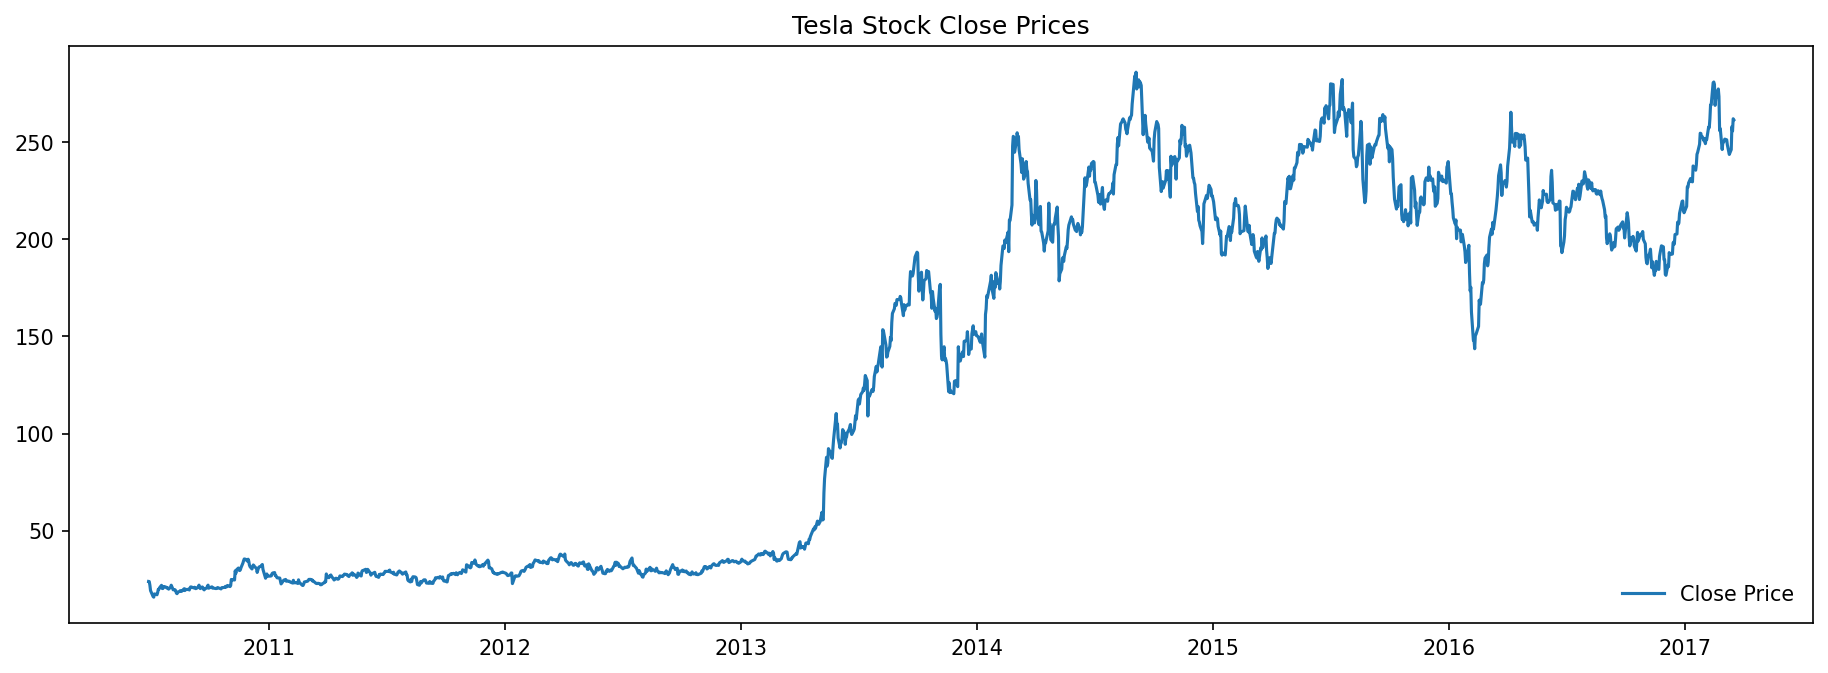

In [138]:
plt.plot(data.index, data["Close"], label = "Close Price")
plt.legend(loc = "lower right", framealpha = 0)
plt.gcf().set_size_inches(15, 5)
plt.gcf().set_dpi(150)
plt.title("Tesla Stock Close Prices")
plt.show()

In [20]:
split_size = int(len(data) * .80)

train = data.iloc[:split_size]
test = data.iloc[split_size:]
print(train.shape)
print(test.shape)

(1353, 6)
(339, 6)


# Standardization

In [72]:
mu = train["Close"].mean()
sigma = train["Close"].std()

train["norm_close"] = (train["Close"] - mu) / sigma

test["norm_close"] = (test["Close"] - mu) / sigma

# Preparation of Dataset

In [122]:
lag = 5
def prep_data(data, lag = 5):
    feature = []
    output = []
    for i in range(len(data)-lag):
        feature.append(data["norm_close"].values[i: i + lag])
        output.append(data["norm_close"].values[i + lag])

    return np.c_[np.array(feature), np.array(output).reshape(-1, 1)]
    
x_train, y_train = prep_data(train)[:, :3], prep_data(train)[:, 3]
x_test, y_test = prep_data(test)[:, :3], prep_data(test)[:, 3]

# Model Building

In [129]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, r2_score



model = GradientBoostingRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(f"r2_score: {r2_score(y_test, y_pred)}")
print(f"rmse: {root_mean_squared_error(y_test, y_pred)}")

r2_score: 0.9500093326695014
rmse: 0.058891070828371764


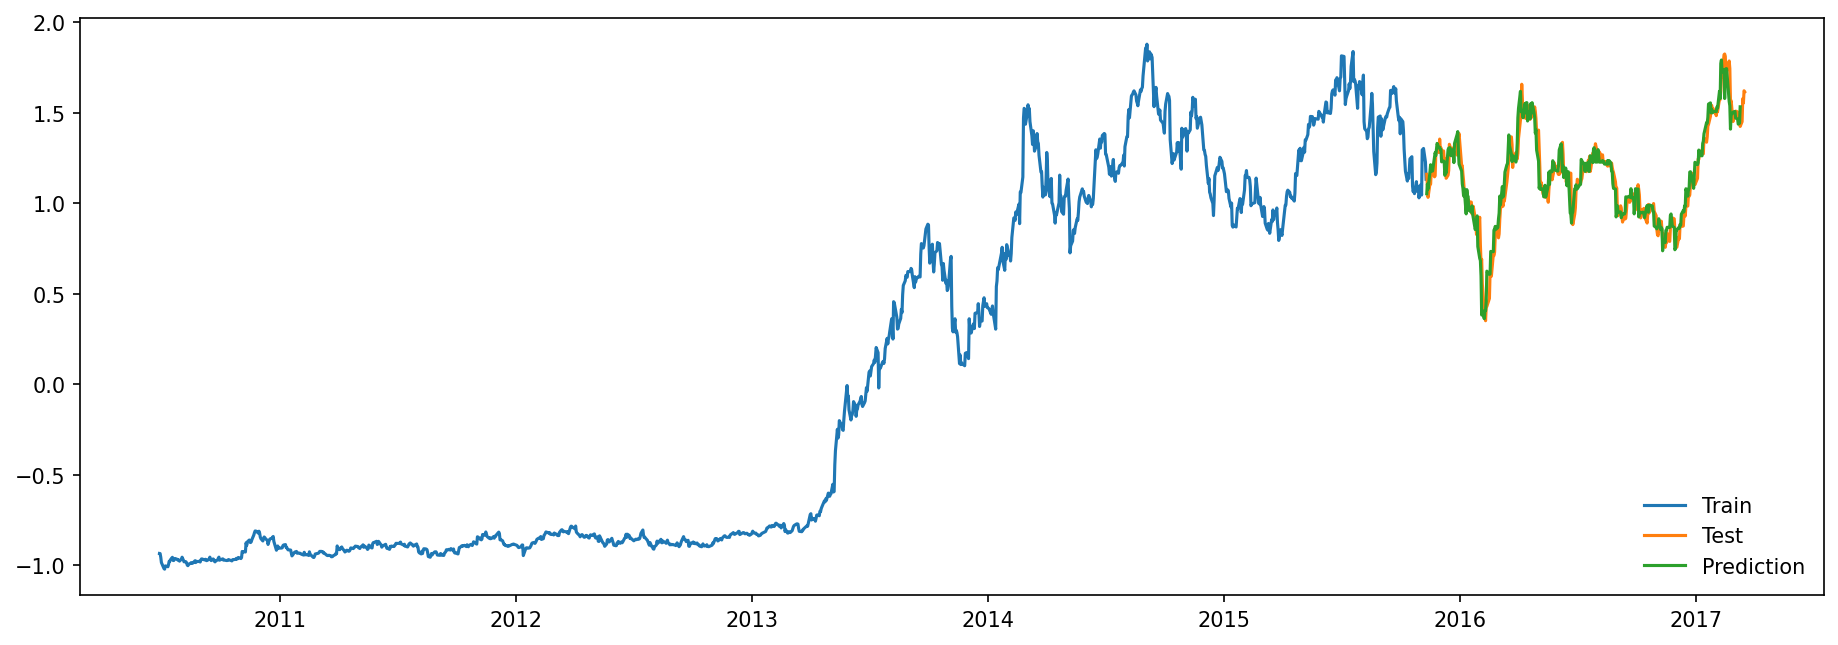

In [130]:
plt.figure(figsize = (15,5), dpi = 150)
plt.plot(train.index, train["norm_close"], label = "Train")
plt.plot(test.index, test["norm_close"], label = "Test")
plt.plot(test.index[:len(test) - lag], y_pred, label = "Prediction")
plt.legend(loc = "lower right", framealpha = 0)
plt.show()

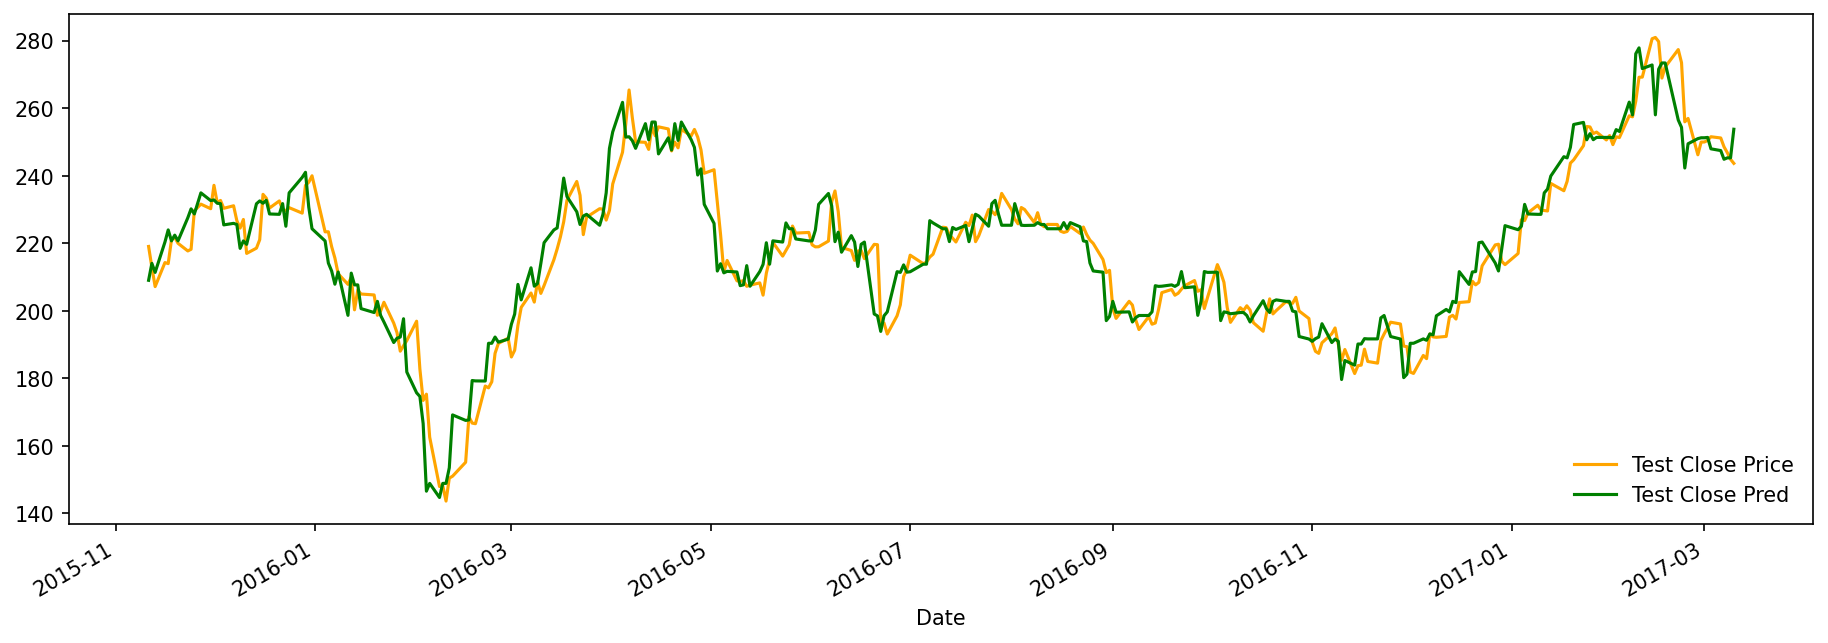

In [140]:
test_pred_table = pd.DataFrame(data = test["Close"].iloc[:len(test) - lag])
test_pred_table["Close_Pred"] = ((y_pred* sigma) + mu).reshape(-1, 1)
test_pred_table.plot(figsize = (15, 5), color = ["orange", "green"])
plt.legend(["Test Close Price", "Test Close Pred"], loc = "lower right", framealpha = 0)
plt.gcf().set_dpi(150)
plt.show()

In [151]:
test_pred_table.reset_index().rename({"Close": "Test Close Price", "Close_Pred": "Test Close Pred"}, axis = 1)

,Date,Test Close Price,Test Close Pred
0,2015-11-11,219.080002,209.055380
1,2015-11-12,212.940002,214.069541
2,2015-11-13,207.190002,211.399482
3,2015-11-16,214.309998,220.380444
4,2015-11-17,214.000000,223.981643
...,...,...,...
329,2017-03-06,251.210007,247.474206
330,2017-03-07,248.589996,244.904060
331,2017-03-08,246.869995,245.316363
332,2017-03-09,244.899994,245.316363
